# COMP5318 - Machine Learning and Data Mining - S1 2018

## Assignment 1

#### Group Members 


*   Yue Cao 440315850
*   Shengyuan Sun 460257820
* Rui Chen 470111585

**Tutors**

*  Dongang Wang
*   Aswani Kumar


**README**

Instruction to run code: 

All code blocks are to be executed in order, except for code block with comment 'DO NOT RUN' written on the first line. 

Code blocks used to draw figure should not be be re-run. All figures are shown in the output. They are the ones marked with 'DO NOT RUN'.



---



## Authenticate and create PyDrive client.

You will be prompted with a link to click on, and give permission to Google Colab to access your Google Drive. If you don't want to give permission to your personal google drive, create a new gmail account, and complete this process using the new account.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


## Import data
Locate the "Data" folder in your drive. Right click and click "share" to get the ID of the folder. Replace < Data folder id > with the id you got. (id should look like "1j8oG_vCmum965Ghg8LdbSkfj-lfi-AZ0" )

In [4]:

file_list = drive.ListFile({'q': "'1j8oG_vCmum9YuVWP8LdbSkfj-lfi-AZ0' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


title: training_desc.csv, id: 1kSoeoaK_TsTHnhSGPXOLNy43jd20G8bH
title: training_data.csv, id: 12-B9GpferXatOB4ACo7GanQ2iBt5O-66
title: test_data.csv, id: 1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk
title: training_labels.csv, id: 1cqErOBjBB91P_xrt4TKuZ91OfTLoUYmx


### Pulling data into Google Colab.

In [0]:
training_data_downloaded = drive.CreateFile({'id': '12-B9GpferXatOB4ACo7GanQ2iBt5O-66'})
training_data_downloaded.GetContentFile('training_data.csv')

training_desc_downloaded = drive.CreateFile({'id': '1kSoeoaK_TsTHnhSGPXOLNy43jd20G8bH'})
training_desc_downloaded.GetContentFile('training_desc.csv')

training_labels_downloaded = drive.CreateFile({'id': '1cqErOBjBB91P_xrt4TKuZ91OfTLoUYmx'})
training_labels_downloaded.GetContentFile('training_labels.csv')

test_data_downloaded = drive.CreateFile({'id': '1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk'})
test_data_downloaded.GetContentFile('test_data.csv') 

### Load data files
This section load in the training data and training label. Please execute the following code in order. 

In [0]:
import io
import numpy as np
from scipy.sparse import *
from scipy import *
from numpy import *
import csv


This code load in the training data. 

To avoid issue with memory consumption, it is loaded as a sparse matrix with the type float32 instead of float64.

In [0]:
S = dok_matrix((20104,13626), dtype=float32) 

f = open("training_data.csv")
reader = csv.reader(f)
i= 0 
app = []
for line in reader:
    S[i] = line[1:13627] #column 1 to 13627 are the actual TF-IDF features 
    app.append(line[0]) #column 0 is the app name
    i = i+1

This coode loads the training label into a dictionary, for easy retrival of label associated with app name. 
The key of the dictionary is app name and the value is its corresponding category. 

In [5]:
f = open("training_labels.csv",'r')
reader = csv.reader(f)
from collections import defaultdict
apptolabel = defaultdict(str)
i=0
for line in reader:
    apptolabel[line[0]] = line[1]
    i=i+1
    
print(i) #check that correct number of lines are read 
    

20104


This code use the app name to retrieve the app label (from the previously built dictionary). 

The labels are stored in the variable 'truelabel'.

In [0]:
truelabel = []
for thisapp in app:
    truelabel.append(apptolabel[thisapp])
    

Convert each app label into one-hot encoding

In [0]:
dicts={}
values = list(set(truelabel))
index= 0
for i in values:
        dicts[i] = index #for each category, convert them into numerical representation
        index = index+1  #eg, 'Education' get mapped to 1, 'Sports' get mapped to 2 etc
len(dicts)

onehot = dok_matrix((20104,30), dtype=int32) 

i = 0
for thislabel in truelabel:
    position = dicts[thislabel] #convert to one hot encoding
    onehot[i,position] = 1 #for number 2 ,  the index at  2 get converted to 1, the rest 29 indices are 0 
    i = i + 1

Check that the correct number of data points and labels have been read into the system.

In [8]:
print(onehot.shape)
print(S.shape)


(20104, 30)
(20104, 13626)


The following lines of code allow checking of memory consumption afer the data loading phase.

In [0]:
import gc
import psutil

In [11]:

gc.collect()

gig = 1<<30
svmem = psutil.virtual_memory()
swap = psutil.swap_memory()

print("Active memory" , svmem.active/gig)
print("free memory", svmem.free/gig)
print("Inactive memory", svmem.inactive/gig)
print(swap)

!free -m
!top

Active memory 3.3540802001953125
free memory 0.16845321655273438
Inactive memory 8.545223236083984
sswap(total=0, used=0, free=0, percent=0, sin=0, sout=0)
              total        used        free      shared  buff/cache   available
Mem:          13029        1634         169           0       11224       11146
Swap:             0           0           0
=top - 15:29:37 up 26 min,  0 users,  load average: 0.22, 0.76, 0.95
Tasks:   7 total,   1 running,   6 sleeping,   0 stopped,   0 zombie
%Cpu(s): 38.7 us,  2.3 sy,  0.0 ni, 48.4 id, 10.6 wa,  0.0 hi,  0.1 si,  0.0 st
KiB Mem : 13341832 total,   172860 free,  1674716 used, 11494256 buff/cache
KiB Swap:        0 total,        0 free,        0 used. 11413044 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
    1 root      20   0   39136   6568   5192 S   0.0  0.0   0:00.08 run.sh      
   65 root      20   0  676252  43376  21632 S   0.0  0.3   0:00.66 node        
   75 root      20   0  7



---


## A. Introduction 


1- What is the aim of the study?


The aim of this study is to classify a set of applications into its categories based on TF-IDF value of selected words. This task is composed of three components. The first task, pre-processing of dataset, deals with the dimension reduction of the data sample using feature selection technique. The second task implements and examines a range of classification algorithm including multiclass logistic regression, Naïve Bayes and multiclass linear regression. Each of these classifiers is trained on a training set, with performance evaluated and compared based on precision and recall on a validation set.  In the final task, the model with the best precision and recall is used to carry out classification on a test set. 


2- Why is this study important?

Classification is one of the main tasks in machine learning and has wide range of applications both in research and in industry. This study is important in that it explores the stages in a typical classification task and examines aspects of decisions to be made during these stages. 

In machine learning task, the dimensions of datasets can often be large. This introduces several problems that can affect the later analysis stages. With the number of dimension being greater than the number of data samples, one can encounter what is known as the curse of dimensionality. [1] Machine learning algorithms typically requires more than one sample for each dimension in order to learn the latent patterns within the sample and to reach a model that can generalise well to unseen data. If, on the other hand, the number of dimension is greater than the number of samples, the machine learning algorithms may fail to distinguish patterns in each dimension, leading to poor performance on testing data. Reducing the number of dimensions, on the other hand, may also lead to poor performance if performed carelessly. It is important that decisions are made thoughtfully. This study thus examines such decision making process in the pre-processing stage.

Apart from pre-processing, the choice of classifier can also impact on classification accuracy. The number of machine learning algorithms, which fall into the two broad category of generative and discriminative, are numerous. Each algorithm is suited to different tasks, depending on the characteristics of the algorithms and characteristic of the dataset. [2] This study, through implementation of different classifiers, compares and contrasts the performance of classifiers and their advantages and disadvantages on this specific dataset of TF-IDF values.




## B. Methods 

### Pre-processing





 
The pre-processing technique used in this study involved counting the number of frequencies associated with each word. This specific pre-processing technique was chosen because the data is sparse, with each word only appearing in only a small proportion of apps. 

First, a histogram was drawn to visualization the distribution of words. The histogram is clearly skewed with almost 12000 out of the 13626 words in the range of 0 to 100. A cumulative density function plot was then plotted to better visualize the probability distribution of the words frequency. The cumulative density plot, narrowed to the range of 0 to 200, clearly shows that 80% of the words appear less than 50 times out of 13627. After performing data splitting such as 10 folds, these words would on average appear less than 5 times across the training data. Words such low frequency would not carry as much information to the models and could be discarded. In this study, we chose to exclude words with frequency less than 40. 

Normalisation was not performed due to the following reasons. All features are presented using TF-IDF,a form of normalisation itself. In addition, the use of TF-IDF implies all features are in the same measurement scale. 

The code below demonstrates this pre-processing stage. 


The following code calculate the frequency of each word

In [0]:
import matplotlib.pyplot as plt
nonzero=[]
for i in range(0,S.shape[1]):
    temp = S[:,i].count_nonzero() #for each feature (word), calculate the number of non zero elements 
    nonzero.append(temp)

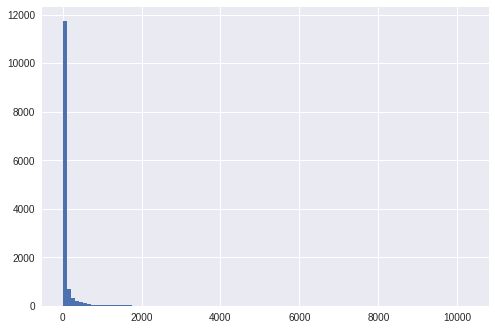

In [24]:
####Do NOT RUN####

plt.hist(nonzero,  bins=100)
plt.show()

**Figure 1.** Histogram of the overall distribution of word frequency. 

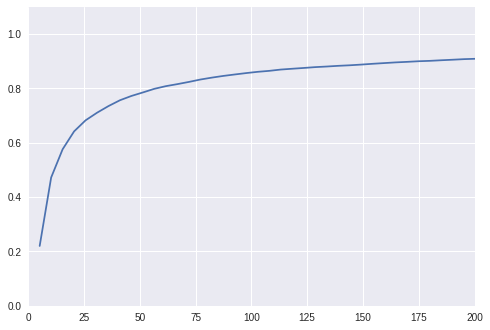

In [25]:
####Do NOT RUN####

base,value = np.histogram(nonzero, bins = 2000, normed = True )
dx = value[1] - value[0]         #calculate the cumulative frequency 
function = np.cumsum(base)*dx

plt.plot(value[1:], function)
plt.ylim([0, 1.1])
plt.xlim([0, 200])  #narrowing the range for clearer result 

plt.show()


**Figure 2. ** Cumulative density function plot, narrowed into the frequency range of 0 to 200

The code below identifies the features to keep by identifying those with frequency >40

In [0]:
nrow = 13627
index=[]
for i in range(1,nrow-1):
    if (S[:,i].count_nonzero() >40): # keep the feature if frequency >40
        index.append(i) #keep track of the index in a list

The code below processes the training data, keeping only the selected features.

In [9]:
Scopy=S
S = S[:,index]
print(S.shape) #check the size of processed data

(20104, 3371)


### Classifier

**Helper** **function**

Please run the following helper function in sequence before running the classifiers.

Helper function for shuffing the dataset. 

Shuffling prevents the data from being ordered in a particular way. This is important for subsequent modelling, especially when the data is to be splitted in folds. An ordered subset of data will serverely affect the pattern in which an algorithm can learn from the data.

In [0]:

def shuffle():
  length = list(range(S.shape[0])) #
  np.random.shuffle(length)
  S[length]  #shuffle the data points using the shuffled index
  
  onehot[length] #shuffle the label according to the shuffled index
  

Shuffle the data once is sufficent 

In [0]:
shuffle()

Helper function for splitting the data into 10 folds, and retrieving one fold each time



In [0]:
def Kcrossvalidation(fold):
  test_length = int(S.shape[0]*0.1)
  
  testindex = list(range(fold*test_length,(fold+1)*test_length))
  totalindex = list(range(0,S.shape[0]))
  trainindex =list(set(totalindex) - set(testindex))


  onehot_train = onehot[trainindex] #split the label into training label with the given index 
  onehot_test = onehot[testindex]   #split the label into testing label

  X_train = S[trainindex]    #split the data into training data      
  X_test =  S[testindex] #split the data into testing data

  X_train = X_train.toarray() #convert the sparse matrix into array, as this actually increase performance in matrix multiplication operation
  X_test = X_test.toarray()
  
  Y_train = onehot_train.toarray() 
  Y_test = onehot_test.toarray()
  
  return (X_train,X_test,Y_train, Y_test) #return one fold of training and validating set 
  

Helper function to convert one hot encoding back to label 

In [0]:
def onehotback(y):
  back = []
  for i in range(0,len(y)):
    #print(i)
    temp = np.argmax(y[i])
    back.append(temp)
  return(back)


Helper function to calculate precision and recall

In [0]:
def precision_recall(prediction,traget):
    """

    :param prediction:
    :param traget:
    :return : precision_list
    :return : recall_list
    :return : Accuracy_list
    """
    recall_list = []  # tp/tp+fn
    precision_list = []  # tp/tp+fp
    Accuracy_list = []  # tp+tn/tp+tn+fp+fn

    for i in range(30):
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        for j in range(len(prediction)):
            if prediction[j] == i:
                if traget[j] == i:
                    tp = tp + 1
                else:
                    fp = fp + 1
            else:
                if traget[j] == i:
                    fn = fn + 1
                else:
                    tn = tn + 1

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        Accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision_list.append(precision)
        recall_list.append(recall)
        Accuracy_list.append(Accuracy)
    return precision_list,recall_list,Accuracy_list

 **Multiclass Logistic Regression **

Multiclass logistic regression is a type of classifier that extends on the concepts of binary logistic regression to multiclass classification. It takes in a feature matrix X of dimension (N, D), a label Y and a weight matrix W of dimension (N,K)  and outputs the probability of a sample belonging to a particular class. (N = number of sample, D = number of features, K = number of classes). 

Multiclass logistic regression is optimised through an iterative process. In each step of the process, the gradient is calculated with respect to the weight of previous iteration. This gradient is then used to update the weight for next iteration. A loss function is calculated based on the weight in each iteration. Iteration continues until the loss function converges. [3,4]
The optimisation algorithm is described with the following formulas. 

The weight matrix W is initiated with randomly generated numbers. The following formulas is used to update this weight matrix in each itereation. 

The formula below shows the calculation of gradient with respect to the Wj, with j being a class in the classification task.  
$$\nabla_{w_{j}}=\frac{e^{w_{j}^{T}x^{(i)}}}{\Sigma_{j=1}^{k} e^{w_{j}^{T}x^{(i)}}}x^{(i)}$$

This formula below shows the calculation of gradient with respect to the correct class yj.
$$\nabla_{w_{y_{j}}}=-x^{(i)}+\frac{e^{w_{j}^{T}x^{(i)}}}{\Sigma_{j=1}^{k} e^{w_{j}^{T}x^{(i)}}}x^{(i)}$$

Once the gradient is obtained, the weight matrix is updated in the opposite direction of the gradient. This can be represented by: W = W - learning rate * gradient.

Finally, the loss, which is used to monitor the convergence of function, is calculated with the following formula.

$$-\frac{1}{m}\sum_{i = 1}^{m}log( \frac{e^{w_{y_{j}}^{T}x^{(i)}}}{\Sigma_{j=1}^{k} e^{w_{j}^{T}x^{(i)}} }  )$$






Multiclass logistic regression in this study is implemented with mini – batch gradient descent. In mini – batch gradient descent, instead of computing the gradient and the loss function based the entire training dataset, n samples are taken as input as one time and the gradient and loss function are computed based on these n samples.   This technique helps to address issues with large dataset, where multiplying between large matrixes can be slow and even incur memory issue.  Multiclass logistic regression is solved using iterative algorithm, therefore it is nature in this study to implement this technique of mini-batch. 

In addition, rigde regularization is implemented. 




In [0]:

def BatchGD(W, X, Y, lamb):
    
    predicted = np.dot(X,W)
    predicted.shape
    #row = each data instance 
    #column = K classes, one column represent one class 
    #eg, (50,30) 
    loss = 0
    gradient = np.zeros(W.shape)
  
    totaltrain =  X.shape[0]
    classes = W.shape[1]
    #eg, 50,   30 

    Y = np.argmax(Y,axis=1)
    #eg, 50, 
     
    #for each sample compute and loss and gradient
    #then average over all sample 
    for i in range(0,totaltrain):
        thisX = X[i] #get the X sample
        truth = Y[i] #get the Y sample
        
        thisrow = predicted[i] #retrieve the correct predicted value with this sample
        #return array of dim 30, 1
        
        softmax_denom = np.sum(np.exp(thisrow)) #compute the exponential of weight times x, then sum the weight up for each class
        
        numerator = np.exp(thisrow[truth]) #the numerator is the exponential of the weight of the correct class times x 
        oneloss = -np.log(numerator / softmax_denom) #loss of one sample 
       
        # compute the gradient
        tempgradient = np.exp(thisrow) / softmax_denom
                             
        #update the gradient for each class 
        for j in range(0, classes):
            gradient[:, j] = gradient[:, j] + (tempgradient[j] * thisX)
        
        loss =  loss + oneloss #sum up each loss 
        gradient[ :, truth] = gradient[:, truth] -  thisX  #update the gradient of the correct class

    loss = loss /totaltrain #average the loss
    loss = loss +  lamb/2 * np.sum(W*W) # use ridge regression 
    gradient = gradient /totaltrain
    gradient = gradient + lamb * W 
    return loss, gradient


In [0]:
def getbatch(i,size):
    X = X_train[i*size:(i+1)*size]
    returny = Y_train[i*size:(i+1)*size]   
    return X,returny

def getlastbatch(i,size):
    X = X_train[(i*size):]
    returny = Y_train[i*size:] #if this is the last batch, then get the number of remaining samples 
    return X, returny
  

In [0]:
def logistic(X_train,Y_train,X_test,lamb):
  total_epochs = 4      #define hyperparameters
  learning_rate = 0.1
  size = 50             #size of mini-batch
  
  W = np.random.random((3371,30)) #initiate the weight matrix 
  total_batch=int(X_train.shape[0]/size)+1  #find the total number of batches in one epoch 
  for epoch in range(0,total_epochs):
      for i in range(0,total_batch):
          if ((i+1) == total_batch):  #if this is the last batch, get n samples, where n<= size of mini-batch 
              batch_x,batch_y = getlastbatch(i,size)
          else:                        #else, get n samples, where n = size of mini-batch 
              batch_x,batch_y = getbatch(i,size)
         
          loss,grad = BatchGD(W,batch_x,batch_y,lamb)  #compute loss and gradient 
          W = W - learning_rate*grad     #update the weight 
          #print(loss)
        
  scores = np.dot(X_test,W)             #after training complete, test the model using validation set 
  y_predicted = np.argmax(scores, axis=1)
  
  return (y_predicted)
  

This is the main function that perform 10 folds cross validation using logistic regression. 

Please run the above helper functions first before running this main function.

In [0]:
precision = []
recall = [] 
for fold in range(0,10):
  X_train,X_test,Y_train,Y_test = Kcrossvalidation(fold)  #get one fold of training and testing data 
  predicted = logistic(X_train,Y_train,X_test,0.06) #train the model, default lambda is set to 0.06
  y_test = onehotback(Y_test)              
  score = precision_recall(predicted,y_test) #calculate the precision and recall
  precision.append(np.mean(score[0]))
  recall.append(np.mean(score[1]))


In [54]:
print(precision)
print(recall)

[0.5942050747717862, 0.598741146048019, 0.5928592386666992, 0.5988774586029677, 0.5991373220702197, 0.5941601668894116, 0.5940840309200506, 0.5945640020604213, 0.5947474468984303, 0.5996239809878612]
[0.5547833827129037, 0.5559991699927179, 0.5542941401546957, 0.5550806699667128, 0.5565110369853151, 0.5547571031176587, 0.5549243820900752, 0.5548199487687396, 0.5551719410324966, 0.5574398295549745]


**Naive Bayes**

Apart from multiclass logistic regression, Naïve Bayes is also one of the common techniques for text classification using word counts. 
In contrast to the discriminative logistic regression that builds a single model for all categories, the generative Naïve Bayes builds a model for each category and choose the one with highest score as the predicted category. The model be summarised with the following formula, where classifier finds the category c that maximise the product of the prior probability of category c and the likelihood of the sample belonging to category c. [5,6]

$$c_{NB} =  \mathop{\arg\max}\limits_{c \in C}P(c)\prod_{f \in F}P(f|c)$$


In this study, Naïve Bayes is implemented using the following formulas. 

The prior, probability of category c, is determined by finding the number of samples in the training data that belongs to category c and dividing by the total number of samples in the training data. 

$$\hat{P}(c) =\frac{Nc}{Ndoc}$$

The likelihood of the sample belonging to category c is calculated in two stages. The first stage requires finding the probability of a word in category c. This is computed by counting the number of times a word appear in category c and dividing by number of times this particular word appear in all categories.  This is represented by the following formula.

$$\hat{P}(w_{i}|c) =\frac{count(w_{i},c)}{\Sigma_{w\in V}count(w,c)}$$

A common issue that can arise from this formula is that words not appearing in training set would be assigned probability 0. This would then bring the likelihood function to 0 in later computation. This study thus implemented a modification of this formula, known as Laplace smoothing. It adds 1 to the numerator and denominator, as shown by the below formula, and prevent word from having probability 0. 

$$\hat{P}(w_{i}|c) =\frac{count(w_{i},c)+1}{\Sigma_{w\in V}(count(w,c)+1)}$$

Once the probability of each word has been found, stage two can be preceded as follows. For each sample, the probability of it belong to category c is calculated by multiplying all the individual probability of each of its word belonging to category c. 

In this implementation, the log of prior and the log likelihood is computed instead of using the original formula. This would avoid issues such as number underflow from multiplying many small probabilities together. 

In addition, this implementation is consisted of two sub-implementations. The default implementation, as shown by the code below, converts the TD-IDF value to a binary form. All TD-IDF value greater than 0 are converted to 1. To use the raw TD-IDF value instead, simply comment out the two lines of code that perform the binary conversion. The default implementation uses the binary form becuase this has been found to give 2% higher precision than using the raw TD-IDF value.



In [0]:
def naivebayes(X_value,y,X_test_value):
    
    prior = defaultdict(int)

    
    ##get the number of instances associated with each label 
    for i in range(0,len(y)):
        label = np.argmax(y[i])
        prior[label] += 1
        
    words = list(range(3371))     

    #create feature dictionary that count the co-occurence of each feature with a topic
    #eg, (photopgrahy, 1823) = 2 
    feature_counts = defaultdict(float)
  
    #pad the dictionary with 0's
    for label in prior.keys():
        for word in words:
            feature_counts[word,label] = 0
       

    
    #get the co-occurence of feature with topic    
    for i in range(0,len(X_value)):
        thisrow = X_value[i] #get a sample 
        thisrow = thisrow.astype(bool).astype(int)
        wordthisrow = np.nonzero(thisrow)[0]
        label = np.argmax(y[i]) #get the topic associated with this sample

        for word in wordthisrow: 
            feature_counts[word,label] += thisrow[word] #update the count, where there is co-occurence of feature with a topic 
       

    #for each topic, count the total number of features that occur with that topic 
    denominator = defaultdict(float)
    for i in range(0, len(X_value)):
        thisrow = X_value[i]
        thisrow = thisrow.astype(bool).astype(int)
         
        label = np.argmax(y[i]) #get the label 
     
        temp = sum(thisrow) #get the total number of words that appear in one sample 
        denominator[label] += temp #update the count 
        
    #apply laplace smoothing                
    lamb = 1
    feature_counts_1 = defaultdict(float)
    for label in prior.keys():
        for word in words:
            feature_counts_1[word,label] = math.log((feature_counts[word,label]+lamb)/(denominator[label]+lamb*3371))
       
 
    
    predicted = []
    
    for i in range(0,len(X_test_value)):
        thisrow = X_test_value[i]
        wordthisrow = np.nonzero(thisrow)[0]
        log_prob = defaultdict(float) 
        for label in prior.keys():
            log_prob[label] = math.log(prior[label]/X_train.shape[0]) #calculate the prior 
            for word in wordthisrow:
                log_prob[label] += (feature_counts_1[word,label])  #calculate the log probability of each word 
       
        log_prob = [(v, k) for k, v in log_prob.items()]
        log_prob.sort(reverse=True)
        predicted.append(log_prob[0][1]) #output the class with highest log probability 
       
    return (predicted)

In [0]:
precision = []
recall = [] 
for fold in range(0,10):
  print(fold)
  X_train,X_test,Y_train,Y_test = Kcrossvalidation(fold)
  predicted = naivebayes(X_train,Y_train,X_test)
  y_test = onehotback(Y_test)
  score = precision_recall(predicted,y_test)
  precision.append(np.mean(score[0]))
  recall.append(np.mean(score[1]))


In [51]:
print(precision)
print(recall)

[0.6022763973010166, 0.5858074934178792, 0.6049837599478268, 0.5976624821388508, 0.5865620930226301, 0.6093887397049033, 0.6009624992800454, 0.6102051437154316, 0.5999173908944321, 0.5916472123827616]
[0.5861261175601736, 0.5737526509146019, 0.5961637878196684, 0.5783151510668747, 0.5743586354907559, 0.599107283584408, 0.5881200526221639, 0.5896647812260086, 0.5980030817710482, 0.5860035847141783]


**Linear Regression**

Linear regression is typically used as a binary classifier, with activation function that constraint the numerical output into probability of class 0 and 1. This binary classification, in theory, can be extended to the multiclass. This study implements such extension using the following closed form solution with ridge regularization.[7,8]

$$(X^TX  + \lambda I)^{-1}X^Ty $$



The input is feature matrix X with dimension (N,D) , one hot encoded label matrix Y with dimension (N, K) and a real value regularization coefficient (N = number of sample, D = number of features, K = number of classes) . The final predicted output has dimension (N,K), which can be argmaxed to give the most probable class for each sample. 

It has been pointed out in literature that linear regression for multi class classification suffers from masking effect, where the decision boundary assigned for some classes is too small and in some cases even non - existence. [9] Nevertheless, it is worth exploring the performance of linear regression for this study. 


In [0]:

def linear(X_train,Y_train,X_test):
  lamb = 2.3
  bracket = lamb*np.eye(X_train.shape[1]) + np.dot(X_train.T, X_train) #calculate what's inside the bracket 
  W = np.dot(np.linalg.inv(bracket), (X_train.T.dot(Y_train))) #finish the calculation 
  y_predicted = np.dot(X_test,W) #prediction 
  
  return (y_predicted)


In [0]:
precision = []
recall = [] 
for fold in range(0,10):
  print(fold)
  X_train,X_test,Y_train,Y_test = Kcrossvalidation(fold)
  predicted = linear(X_train,Y_train,X_test)
  y_test = onehotback(Y_test)
  y_predicted = onehotback(predicted)
  score = precision_recall(y_test,y_predicted)
  precision.append(np.mean(score[0]))
  recall.append(np.mean(score[1]))
 



In [99]:
print(precision)
print(recall)

[0.6429515520168786, 0.6311655353439943, 0.6194951422172766, 0.6430504639549984, 0.6291052677890215, 0.6360818885711249, 0.6316073617915631, 0.6554664890499605, 0.6400025710553793, 0.6397143193168396]
[0.6395533257320285, 0.6283765623586592, 0.6189052959798882, 0.6308278105289504, 0.6223100147159681, 0.633473279799632, 0.6294052620719737, 0.6374730961482491, 0.6379736858007146, 0.6422608547617791]


**Support Vector Machine (Guassian Kernel)**

Implementation with Support Vector Machine with Gaussian Kernel has been attempted using Sequantial Minimal Optimization. A one versus rest approach was initially attemped, the precision was however only 40%. 
A possible issue causing the lower performance of one versus rest SVM is class imbalance, resulting from converting one class to positive class and rest 29 classes to negative class. While one versus one apporach is known to address this class imbalance isue, the number of one versus one SVMs that needs to be implemented is 29*30/2 = 435. 

Hence, not further implementation was attempted to extend the single SVM for classification of 30 classes. 
The code is attached for reference only. No experiment will be conduced using this implementation. 


In [0]:

#### DO NOT RUN ####

#define the guassian kernel 
def rbf(xi,xj):
    exponent = - gamma * np.linalg.norm(xi-xj) ** 2
    return (np.exp(exponent))

#update the alpha according to certain constraints
def contraint( C, a_i, a_j, y_i, y_j):
        if(y_i != y_j):
            return (max(0, a_j - a_i), min(C, C - a_i + a_j))
        else:
            return (max(0, a_i + a_j - C), min(C, a_i + a_j))


#updation rule 
def compute_error(x, y, w, b):
    temp = (np.dot(w.T, x.T) + b)
    temp = np.sign(temp).astype(int)
    temp = temp -  y
    return (temp)
  
  
# initialize parameters
m = X_train.shape[0] 
a = np.zeros(m)
a_old = np.zeros(m)
b = 0

tol = 0.01
num_changed_alphas = 0 
passes = 0
max_passes = 10
C= 1
gamma =0.03

Y_train = onehotback(Y_train)
Y_train[Y_train!=19] = -1 #convert the rest of the class into negative class 
Y_train[Y_train ==19] = 1 #convert one of the class into positive class 


from random import randint

while (passes < max_passes):
    changed_alphas=0 
    print(passes)
    passes = passes + 1
    
    for i in range(0,X_train.shape[0]):
        w = np.dot(alpha*y, X)
        b = y - np.dot(w.T, X.T)
       
        error_i = compute_error(x[i],y,w,b)
        
        if ((y[i]*error_i < -tol and a[i] < C ) or (y[i]*error_i > tol and a[i] > 0)):
            
            j = i
            while (j == i):
                j = randint(0, m)

            error_j = compute_error(x[j],y[j],w,b)
           
            a_old[i] = a[i]
            a_old[j] = a[j]
            
           
            L,H = contraint(C,a[i],a[j],y[i],y[j])
            
            if (L == H):
                continue
            
            n = 2*rbf(x[i],x[j]) - rbf(x[i],x[i]) - rbf(x[j],x[j])
            
            if (n >= 0):
                continue 
            
            a[j] = a[j] - y[j]*(error_i - error_j)/n
             
            if (a[j] > H):
                a[j] = H
            elif (a[j] < L):
                a[j] = L
            else:
                a[j] = a[j]
             
            if (abs(a[j] - a_old[j]) < 0.00005):
                continue
            
            a[i] = a[i] + y[i]*y[j]*(a_old[j] - a[j])
            
            b1 = b - error_i - y[i]*(a[i] - a_old[i])*rbf(x[i],x[i]) - y[j]*(a[j]-a_old[j])*rbf(x[i],x[j])
            b2 = b - error_j - y[i]*(a[i] - a_old[i])*rbf(x[i],x[j]) - y[j]*(a[j]-a_old[j])*rbf(x[j],x[j])
            
            if (0<a[i]<C):
                b = b1
            elif (0<a[j]<C):
                b = b2
            else:
                b = (b1+b2)/2
            
            changed_alphas = changed_alphas + 1
            #print(num_changed_alphas)
    
    
        passes = passes + 1


    
predicted=np.sign(np.dot(w.T, X_test.T) + b).astype(int)
   

## C. Experiments and Results 

### Accuracy

**Mean Precision and Recall**

Below report the average precision and recall associated with each classifer, calculated using 10 folds cross - validation as shown in the previous section. 

Runtime of each classifier is included in bracket. The runtime is defined as the time to train the classifer on one fold of training data. 

Specification of computer used for performance evalution:

Hardware:
CPU :1.6 GHz Intel Core i5, Memory : 4 GB 1600 MHz DDR3

Software: Google Colab


Multiclass Logistic Regression **(152 seconds)**
*   Precision:  mean = 0.5961 , SD = 0.0025
*   Recall: mean = 0.5554 , SD = 0.0009

Naive Bayes (Binary) **(7 seconds)**
*   Precision: mean = 0.5989, SD = 0.0082
*   Recall: mean = 0.5870, SD = 0.0088

Naive Bayes (TD-IDF) **(7 seconds)**
*   Precision: mean = 0.5724, SD = 0.0083
*   Recall: mean = 0.5637, SD = 0.0094

Multiclass Linear Regression **(8 seconds)**
*   Precision: mean = 0.6369, SD = 0.0093
*   Recall: mean = 0.6321, SD = 0.0072







**Per Class Precision **

Precision for each individual class was calculated and reported in the table below. Highlighted cells shown precision <0.50. 

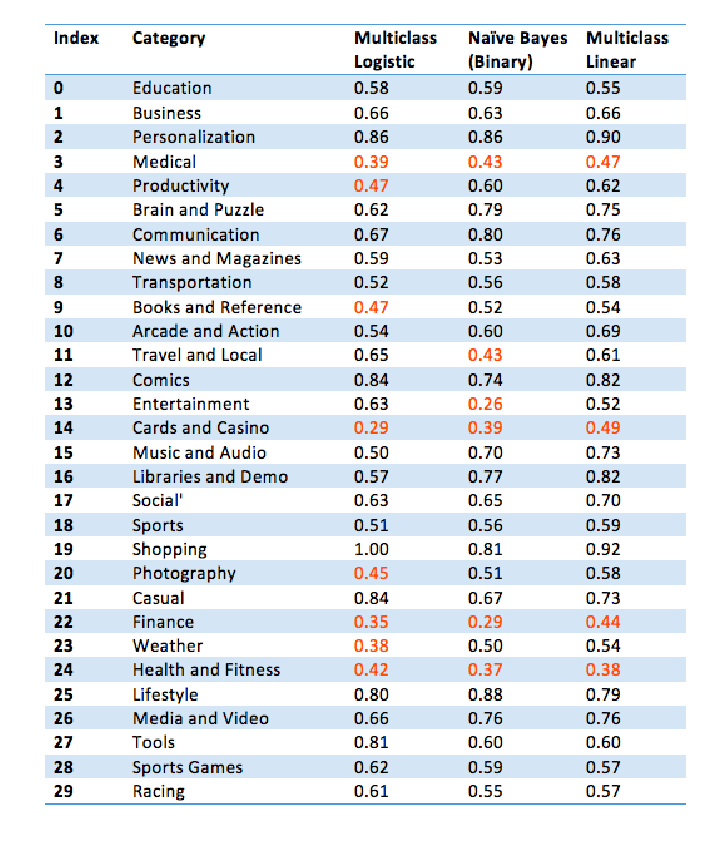

In [45]:
####Do NOT RUN####

img = Image.open('table (1).png')
plt.figure(figsize=(25,15))
plt.imshow(img)
plt.axis('off')
plt.show()

### Extensive Analysis



Helper function to upload figures

In [0]:
import matplotlib.pyplot as plt 
from PIL import Image
from google.colab import files

In [0]:

uploaded = files.upload()
for k, v in uploaded.items():
    open(k, 'wb').write(v)

**Hyperparameter Analysis **

Apart from the single reported accuracy in the above section, extensive analysis was also carried out with logistic regression involving hyperparameter tuning. Two hyperparameters were tuned in this study, the regularization coefficient and the number of epochs. Regularization controls the weights of the features. An overly small regularization term may over reduce the weights towards zero, leading to over simplified model. In contrast, an overly large regularization term may not place enough constraint to the model, leading to a model that may overfit. 
In this study,  lambda in the range of 0 to 20 was initially tested. This larger value span help to detect a narrower range of value to then fine tune. At the range 0 to 20, it was observed that the accuracy rapidly decreases from value beyond 1. Hence a set of smaller values ranging from 0 to 1 were tested and precision on validation set is shown in the figure below. The figure suggested that lambda of value 0.06 provides the best validation precision. This is also the default lambda used in the previous classification section. 




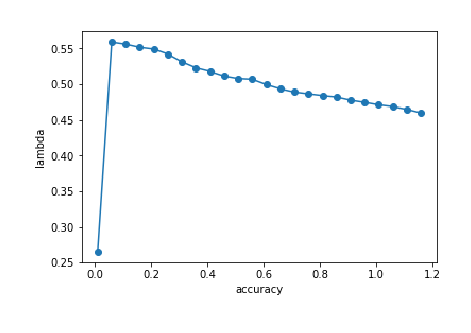

In [60]:
####Do NOT RUN####

img = Image.open('hyperparam (1).png')
plt.imshow(img)
plt.axis('off')
plt.show()

**Figure 3** Lambda versus validation accuracy 

The number of epochs was also analysed. It was initially suspected that greater number of epochs might lead to more complicated model that overfit. The figure below plots the losses in smooth line and accuracy in dotted line with increasing number of epochs. The figure suggested that while increasing the number of epochs did not cause drop in validation accuracy, it was nevertheless unnecessary to continue training. The default number of epochs was decided to be 4. 



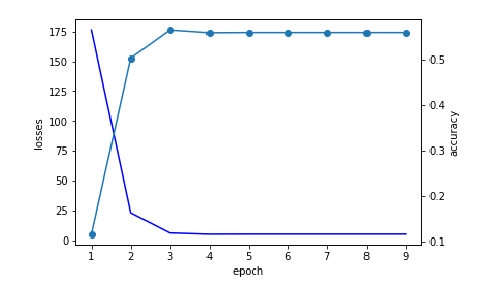

In [61]:
####Do NOT RUN####

img = Image.open('epoch.png')
plt.imshow(img)
plt.axis('off')
plt.show()

**Figure 4.**  Loss and validation accuracy versus number of epoch. Loss is shown in smooth line, accuracy is shown in dotted line

Similarity, the regularization term in ridge linear regression was also tuned and the best number set as default in the classification section. 

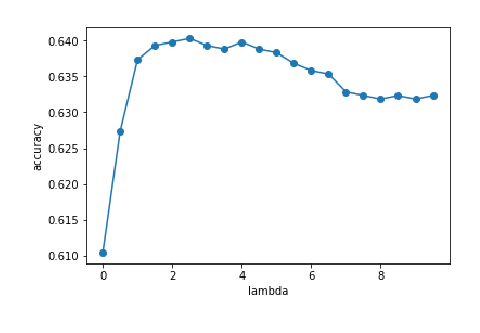

In [95]:
####Do NOT RUN####

img = Image.open('linear.png')
plt.imshow(img)
plt.axis('off')
plt.show()

**Figure** **5. ** 
Lambda versus validation accuracy 

**Comparison to Sklearn implementation **

The Sklearn package in Python is one of the most widely used source for machine learning algorithms. In this section, the Sklearn implementation of Naive Bayes, Linear Regression and Logistic Regression is used to allow a comparison of model performance. 



In [0]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
X_train,X_test,Y_train,Y_test = Kcrossvalidation(1)

The following code runs Sklearn's implementation of Naive Bayes. Compared to Sklearn's precision of 36%, our implementation achieved a precision of 60%, which is 67% better. 

In [85]:
gnb = GaussianNB()
Y_train_NB = onehotback(Y_train)
y_predicted= gnb.fit(X_train, Y_train_NB).predict(X_test)
y_test_NB = onehotback(Y_test)
score = precision_recall(y_test_NB,y_predicted)
print(np.mean(score[0]))
print(np.mean(score[1]))

0.36681053874119457
0.3779659794520277


The following code runs Linear Regression. Our implementation achieved a precision of 64%, which is still better than Sklearn's implementation. 

In [86]:
regr = linear_model.LinearRegression()
y_predicted = regr.fit(X_train, Y_train).predict(X_test)
y_predicted_Linear = np.argmax(y_predicted,axis=1)
y_test_linear = onehotback(Y_test)
score = precision_recall(y_test_linear,y_predicted_Linear)
print(np.mean(score[0]))
print(np.mean(score[1]))

0.6055110368035923
0.6073997107919133


Sklearn slightly outperforms our implementation on Logistic Regression, with a precision 2.5% better than our implementation. Of the three implemented classifiers, Logistic Regression is the hardest one to tune due to having the most number of hyparameters. In this study, only lambda and number of epochs was tune. The rest of the hyperparamters including learning rate, size of mini-batch and decision over lasso versus ridge have not yet been tuned. These could all contribute to the reason why our implementation failed to surpass Sklearn.

In [87]:
logreg = LogisticRegression()

Y_train_log = onehotback(Y_train)
y_predicted_log = logreg.fit(X_train, Y_train_log).predict(X_test)
y_test_log = onehotback(Y_test)

score=precision_recall(y_test_log, y_predicted_log)
print(np.mean(score[0]))
print(np.mean(score[1]))

0.6251515417545931
0.6365366820033492


**Analysis of Per Class Precision**

The table provided in the accuracy section presents precision of each class across three classifiers. It can be seen from the table that while most classes has good prediction under the three classifiers, there are a few classes such as Medical (index 3) and Finance (index 22) that has less than 0.5 accuracy  across all the three classifiers. This consistency in low accuracy across classifiers suggests that the problem may lie in the feature selection stage, rather than in the choice of classifiers. Hence, analysis of the discarded features versus class precision was carried out. For each class, the total number of times that an excluded features appear in the class was computed. To make this statement clearer, consider column 2 being the discarded feature with 5 values, of which 3 values appear in ‘Education’ apps. The number of discarded feature in ‘Education’ apps is then counted as 3, the total number of times that this feature appear in a class, instead of 1, the number of distinct features that are discarded in this class.

The figure below plots discarded features versus precision for each class. Blue line represents precision of each class and red line represents the total number of times the discarded features occur in each class. It can be seen that for most classes, the height of the two lines are in opposite of each other. The lower the precision (blue line),  the higher the total number of discarded feature (red line), and vice versa. 


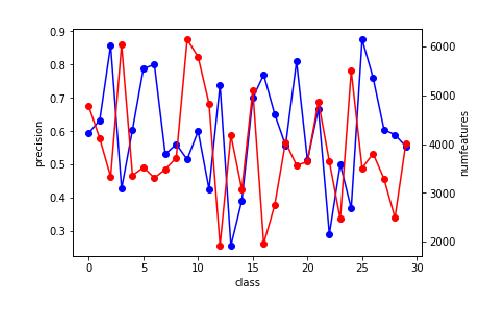

In [48]:
####Do NOT RUN####

img = Image.open('checkfeature.png')
plt.imshow(img)
plt.axis('off')
plt.show()


**Figure 6.**  Comparison of discarded features versus class precision. Y-axis shows index of each class, for the name of the class, please refer to the table in the previous section.  To interpret this figure: index 0 represents the class Education.  Blue line shows the precision of this class is 0.68, red line shows that from all the discarded features (words),  a total of 4100 words appear in this class.

## D. Export Results 

URL address of the "predicted_labels.csv"

https://drive.google.com/open?id=1FgAkOz_18gj3M1N5VsDb8oly_G3DJ5Sz

The following code demonstrates how the labels are producted from the test data

First, the test data is read into the system. The same feature extraction method used in training data is then applied to this test data. 

In [26]:

SS = dok_matrix((2233,13626), dtype=float32)
f = open("test_data.csv",'r')
reader = csv.reader(f)
i = 0
testapp = []
for line in reader:
    #print(i)
    SS[i] = line[1:13627]
    testapp.append(line[0])
    i = i+1

SS_edited = SS[:,index]
SS_edited.shape #check the data is in correct shape


(2233, 3371)

One fold training data is used to predict the test data using one of the classifier.

In [0]:
SS_edited = SS_edited.toarray()
X_train,X_test,Y_train,Y_test = Kcrossvalidation(1)
predicted = linear(X_train,Y_train,SS_edited)
y_test = onehotback(Y_test)
y_predicted = onehotback(predicted)

The numerical label is mapped back to the propoer label. For example, 24 is mapped to Health and Fitness

In [0]:
inverse = {v: k for k, v in dicts.items()}
savelabel = []
for i in y_predicted:
    templabel = inverse[i]
    savelabel.append(templabel)

The label is then appended with the app name and wrote to csv

In [34]:
finallabel = np.column_stack((testapp,savelabel))
np.savetxt("predicted_labels.csv",finallabel , delimiter=",",fmt='%s')
print(finallabel)


[['dalmax.games.turnBasedGames.connect4' 'Brain and Puzzle']
 ['com.holfeld.japaneseplusfree' 'Travel and Local']
 ['com.mobileApp.controller' 'Personalization']
 ...
 ['com.daeha.android.app.repeat_ja_ko' 'Books and Reference']
 ['com.sec.android.allShareControl' 'Media and Video']
 ['com.mobileriders.butt.sculpting.exercises' 'Health and Fitness']]


https://drive.google.com/open?id=1FgAkOz_18gj3M1N5VsDb8oly_G3DJ5Sz

## E. Discussion 


In this study, Logistic Regression, Naïve Bayes and Linear Regression are implemented, with mean precision 60%, 60% and 64% respectively. 

Both Logistic Regression and Naïve Bayes are linear classifiers, with logistic regression being discriminative classifier and the latter being discriminative. 

Naive Bayes holds strong assumption of distributed independence between features. If two features are correlated, Naïve Bayes will give both features higher weights, leading to overestimation of the final probability. In comparison, logistic regression does not have such underlying assumption and can handle correlated features by reweighting the correlated features. It has been stated in literature that independency is usually not violated in text classification problem. This may suggests one of the reasons that both Naïve Bayes and Logistic Regression perform similarity in this task.[10] 

In addition to feature correlation that is found to affect performance, literature also states the number of training example being a contributor of model accuracy.[4] It is found that Logistic Regression requires more samples to reach its asymptotic error compared to Naïve Bayes. Naïve Bayes and Logistic Regression thus have similar performance when the number of training instances is small, yet Logistic Regression prevails in performance as the number of training instances grows. Hence, another reason accounting for similar performance is that the number of training examples is yet sufficient for Logistic Regression to reach its asymptotic error. 

In this study, Linear Regression outperformed both Logistic Regression and Naïve Bayes. Linear Regression has been raised in literature as an unsuitable method for multi-class prediction due masking problem. This issue, however, did not arise for the particular dataset used in this study. The table in previous section shown that the precision for each class is comparable to Logistic Regression and Naïve Bayes, with no particular class exhibiting signs of masking effect. 




## F. Conclusion and future work 

In this study, we implemented three common classification algorithms, Multiclass Logistic Regression, Naïve Bayes and Multiclass Linear Regression. For this particular given dataset, Logistic Regression and Naïve Bayes achieved identical precision, with Naïve Bayes having slightly higher recall. Multiclass Linear Regression outperformed both classifiers in terms of precision and recall and was not found to suffer from masking problem. 

In this study, the numbers of excluded features were found to be non - uniform across each class, resulting in classes with more excluded features having lower precision. For future work, different approaches of dimension reduction and feature extraction algorithm can be explored to examine effect on per class performance.  

The dataset used in this study is found to have well balanced sample size across each class. Further experimentation would involve testing the same set of classifiers on an unbalanced data and compare and contrast their performance on balanced versus unbalanced data. 

Lastly, all the classifiers implemented in this study are linear classifiers. It is of interest to see how non-linear classifiers perform on this particular dataset. Future work could be done on implementing non – linear classifiers such as decision tree. 



## G. References


1.   Friedman, J. H. (1997). On bias, variance, 0/1—loss, and the curse-of-dimensionality. Data mining and knowledge discovery, 1(1), 55-77.
2.   Hilbig, B. E., & Moshagen, M. (2014). Generalized outcome-based strategy classification: Comparing deterministic and probabilistic choice models. Psychonomic bulletin & review, 21(6), 1431-1443.
3. Böhning, D. (1992). Multinomial logistic regression algorithm. Annals of the Institute of Statistical Mathematics, 44(1), 197-200.
4. Ng, A. Y., & Jordan, M. I. (2002). On discriminative vs. generative classifiers: A comparison of logistic regression and naive bayes. In Advances in neural information processing systems,  841-848.
5. Murphy, K. P. (2006). Naive bayes classifiers. University of British Columbia, 18.
6. D. Jurafsky and J. H. Martin, (2000). Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition, Prentice-Hall, Upper Saddle River, NJ,.
7. Collins, M., Schapire, R. E., & Singer, Y. (2002). Logistic regression, AdaBoost and Bregman distances. Machine Learning, 48(1-3), 253-285.
8. Friedman, J., Hastie, T., & Tibshirani, R. (2001). The elements of statistical learning (Vol. 1, pp. 337-387). New York: Springer series in statistics.
9. Zhang, C.M., Fu, H., (2006). Masking effects on linear regression in multi-class classification. Statist. Probab. Lett. 76, 1800–1807
10. Zhang, H. (2004). “The Optimality of Naive Bayes.,” in FLAIRS Conference, AAAI Press.
